In [11]:
# By:
# Mayank Sharma 2019PCS0005
# Nikita Sharma 2019PCS0007
# Pranav Joshi  2019PCS0022

In [13]:
import numpy as np
import pandas as pd
from math import ceil
from cnn_forward_propagation.fpass import *
from cnn_backward_propagation.bpass import *
from NeuralNetwork import *

## .

In [14]:
# In the algorithm proposed previously,
# we were computing the convolution for 
# different number of input channels,
# and different number of kernels seperately
# i.e. one or many
# Similarly, we were computing the pooling
# for different number of channels separately.

# In the below implementation,
# we are computing the above using
# common snippets, with help of vectorization
# and code simplification/cleaning.
# this helps to avoid unecessary repitition
# of significant portion of code. 

## Fully Connected Neural Network


In [15]:
import numpy as np

'''
Defining Generic Class for a fully connected Neural Network

Arguments
----------

input_nodes: Numbers of nodes in input vector
hidden_nodes: Number of activation functions in hidden node
output_node: Number of nodes in output layer

'''


class NeuralNetwork(object):

    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes**-0.5, 
                                       (self.input_nodes, self.hidden_nodes))

        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes**-0.5, 
                                       (self.hidden_nodes, self.output_nodes))
        self.lr = learning_rate
        
        self.activation_function = lambda x : 1/(1+np.exp(-x))  # sigmoid calculation.

    def forward_pass_train(self, X):

        ### Forward pass ###
        
        #Hidden layer.
        hidden_inputs = X.dot(self.weights_input_to_hidden) # signals into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # signals from hidden layer

        # Output layer
        final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer
        
        return final_outputs, hidden_outputs
      
    
    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        
        ''' Implement backpropagation
         
            Arguments
            ---------
            final_outputs: output from forward pass
            y: target (i.e. label) batch
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
        '''
       
        ### Backward pass ###

        # Output error
        error = (y - final_outputs) # Output layer error is the difference between desired target and actual output.
        
        # Calculating the hidden layer's contribution to the error
        hidden_error = error.dot(self.weights_hidden_to_output.T)
        
        #Backpropagated error terms.
        output_error_term = error
        
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Weight step (input to hidden)
        delta_weights_i_h += hidden_error_term * X[:, None]
        
        # Weight step (hidden to output)
        delta_weights_h_o += output_error_term * hidden_outputs[:,None]
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        
        ''' Update weights on gradient descent step
         
            Arguments
            ---------
            delta_weights_i_h: change in weights from input to hidden layers
            delta_weights_h_o: change in weights from hidden to output layers
            n_records: number of records
        
        '''
        self.weights_hidden_to_output += self.lr * delta_weights_h_o/n_records # update hidden-to-output weights with gradient descent step
        self.weights_input_to_hidden += self.lr * delta_weights_i_h/n_records # update input-to-hidden weights with gradient descent step

    def run(self, features):

        ''' Run a forward pass through the network with input features 
        
            Arguments
            ---------
            features: 1D array of feature values
        '''
        
        #### Forward pass ####

        # Hidden layer
        hidden_inputs = features.dot(self.weights_input_to_hidden) # input feature vector into hidden layer
        hidden_outputs = self.activation_function(hidden_inputs) # output from hidden layer
        
        # Output layer
        final_inputs = hidden_outputs.dot(self.weights_hidden_to_output) # signals into final output layer
        final_outputs = final_inputs # signals from final output layer 
        
        return final_outputs

    def train(self, features, targets):

        ''' Train the network on batch of features and targets. 
        
            Arguments
            ---------
            
            features: 2D array, each row is one data record, each column is a feature
            targets: 1D array of target values
        
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        for X, y in zip(features, targets):
            
            final_outputs, hidden_outputs = self.forward_pass_train(X)  # Implementing the forward pass function below
            
            # Implementing the backproagation function below
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)

## Test Fully Connected Neural Network

In [16]:
import unittest


inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.004s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Testing CNN Forward Pass for Different Filter Settings for different Random Input Images

In [17]:
def TestForwardPass():

  for i in range(2,6):
    
    # dimensions of the convoluted image
    # n_c = n_c_in + np.random.randint(1, 10)  # Number of kernels
    f_h, f_w = i, i # Filter height and width (m2, n2)
    padding, stride = i, i
    print('For filter with size : ({}, {})'.format(f_h, f_w), ' Padding :',padding, ' Stride :', stride, '\n')

    # input image dimensions
    for j in range(5, 12):
      val = np.random.randint(4, j)
      n_h_in, n_w_in = f_h + val, f_w + val   # m1, n1

      n_c_in = np.random.randint(1, 10)
      n_c = n_c_in + np.random.randint(1, 10)  # Number of kernels

      # Initializing input dataset
      data_size = np.random.randint(10, 50)
      A_in = np.random.randn(data_size, n_h_in, n_w_in, n_c_in)

      # Initializing weights
      W = np.random.randn(f_h, f_w, n_c_in, n_c)
      b = np.random.randn(1, 1, 1, n_c)
  
      Z, A1, cache_conv1 = CNN_node_forward(A_in, W, b, padding, stride, relu)

      pool_size, stride_pool = 2, 2
      P1, cache_pool1 = MAX_pool_forward(A1, pool_size, stride_pool)
      
      print(f'Input Image Dimesions : {A_in.shape}\t Convoluted Image Dimensions : {A1.shape}\t Image After Pooling :{P1.shape}')
    print()

TestForwardPass()

For filter with size : (2, 2)  Padding : 2  Stride : 2 

Input Image Dimesions : (12, 6, 6, 9)	 Convoluted Image Dimensions : (12, 4, 4, 15)	 Image After Pooling :(12, 2, 2, 15)
Input Image Dimesions : (30, 6, 6, 3)	 Convoluted Image Dimensions : (30, 4, 4, 4)	 Image After Pooling :(30, 2, 2, 4)
Input Image Dimesions : (20, 7, 7, 1)	 Convoluted Image Dimensions : (20, 5, 5, 2)	 Image After Pooling :(20, 3, 3, 2)
Input Image Dimesions : (21, 6, 6, 8)	 Convoluted Image Dimensions : (21, 4, 4, 12)	 Image After Pooling :(21, 2, 2, 12)
Input Image Dimesions : (46, 8, 8, 5)	 Convoluted Image Dimensions : (46, 5, 5, 11)	 Image After Pooling :(46, 3, 3, 11)
Input Image Dimesions : (20, 8, 8, 1)	 Convoluted Image Dimensions : (20, 5, 5, 8)	 Image After Pooling :(20, 3, 3, 8)
Input Image Dimesions : (12, 7, 7, 9)	 Convoluted Image Dimensions : (12, 5, 5, 11)	 Image After Pooling :(12, 3, 3, 11)

For filter with size : (3, 3)  Padding : 3  Stride : 3 

Input Image Dimesions : (40, 7, 7, 6)	 Convo

## Loding and Preprocessing MNIST DataSe

In [18]:
from keras.datasets import mnist
from keras.utils import to_categorical
from matplotlib import pyplot

In [19]:
def load_data():

  (trainX, trainY), (testX, testY) = mnist.load_data()
  
  print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
  print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
  
  for i in range(9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(trainX[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

  print('Training Samples Size ', trainX.shape, ' Training Labels Shape ', trainY.shape)
  print('Test Samples Size', testX.shape, ' Test Labels Shape', testY.shape)

  # Flatten out each image into single channel

  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # Perform one hot encoding

  trainY = to_categorical(trainY)
  testY = to_categorical(testY)

  return trainX, trainY, testX, testY

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


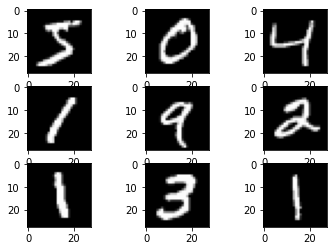

Training Samples Size  (60000, 28, 28)  Training Labels Shape  (60000,)
Test Samples Size (10000, 28, 28)  Test Labels Shape (10000,)


In [20]:
features_train, labels_train, features_test, labels_test = load_data()

In [21]:
def preprocess_data(train, test):

  # convert from integers to floats
	
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')
	
  # normalize to range 0-1
	
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0
	
  # return normalized images
  
  return train_norm, test_norm